<h1 align=center><font size = 5>Battle of Neighborhoods</font></h1>

### Great event venue in Toronto, canada

## Table of Contents

1. <a href="#item1">Project description: business problem and interested audience in this project.</a>
2. <a href="#item2">Data requirements </a>  
3. <a href="#item3">Methodology</a>  
4. <a href="#item4">Results </a>  
5. <a href="#item5">Discussion and conclusion </a>  




## 1. Project Description:

According to “The 2016 Event Professionals of Tomorrow Report”, selecting an event space is often reported as one of the most important and challenging aspect in the planning process. The location of the event venue is crucial for optimizing event attendance and should be an appropriate place for the target audience.  The type of facility components in the chosen venue should also fit the event. Moreover, suitable lodging accommodations within a reasonable distance of the event and nearby organic event networking opportunities increase the success of the event. 


This project aims to find great venues nearby available event facilities in a city that fulfill the types of events and their requirements. FourSquare data and folium’s visualizing aid as well as data analysis and clustering techniques will solve the problem discussed in this the project.


The interested audiences are event coordinators looking for great venue that not only sets the scene but also comply with requirements of the event and experiences of the participants.  


## 2. Data requiremnts

The main dataset regarding the available event facilities in Toronto city are obtained from the official webpage https://www.toronto.ca/city-government/data-research-maps/open-data.  This database is a compilation of all event spaces within the 44 City wards in Toronto city,  available on a rental basis, for performances, exhibitions, visual arts, screen based performances, heritage events etc. The fields in the dataset are: FACILITY NAME, Full Address, Street #, Street Name, Suite, City, Province, Postal Code, Ward, type of space and ownership of facilities.


The neighborhood data for the city of Toronto is also needed. However, the data is not readily available. Instead it has to be scrapped form a Wikipedia page at https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M  , cleaned and put in to a dataframe.


For exploring and recommending event facilities across different venues in Toronto city, the FourSquare API interface is also used. The data gathered are then arranged in a dataframe for clustering and visualization.


## 3. Methodology

The aim of the project is to develop a decision-making tool for great event space selection in Toronto city.  The tool is composed of three modules: one module is preliminary analysis of all event space in Toronto city by type and location. This module deals with data wrangling and preprocessing to make it suitable for the next stage. Following the data preprocessing, location information (Latitude and Longitude) for event facilities would be made available to Foursquare API server as HTTP requests using zip codes of the Toronto city streets. Foursquare API search feature would then be used to gather relevant information regarding nearby venues of the city streets. The http request limitations for the number of venues and radius of nearby places are considered. 


The second module is the territorial diagnosis based on a clustering analysis of the city addressed. Unsupervised K-mean clustering algorithm is carried out to cluster categories of venues nearby a given event locations. Folium is used to visualize the street venue cluster over an interactive map. 


A final module known as the recommendations module derive insights for selecting great venues and draw conclusions. 




In [4]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from urllib.request import urlopen

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import folium # map rendering library
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.pylab as plt

from bs4 import BeautifulSoup

# import k-means from clustering stage
from sklearn.cluster import KMeans



print('Libraries imported.')

Libraries imported.


Let's get gather data regarding available event spaces in Toronto city. This is available from Toronto government database at http://opendata.toronto.ca/gcc/MSFC_44%20Wards_Complete_Final.xlsx

In [5]:
link = urlopen("http://opendata.toronto.ca/gcc/MSFC_44%20Wards_Complete_Final.xlsx")
xd = pd.ExcelFile(link)
xd.sheet_names
[u'Database']
df = xd.parse()
#df['Full Address'] = df.apply(lambda x: x['Full Address'][:-8], axis = 1)
df['Full Address'] = [a.replace(b, '').strip() for a, b in zip(df['Full Address'], df['Postal Code'])]
df['Full Address'] = df['Full Address'].str.replace(r',$', '')
df['Postal Code'] = df['Postal Code'].str[:3]
df.fillna(0, inplace=True)
df.head()

,FACILITY NAME,Full Address,Street #,Street Name,Suite,City,Province,Postal Code,Ward,Performance,Exhibition / Visual Arts,Screen Based,Library,Multipurpose,Heritage,OWNERSHIP
0,Thistletown CC,"925 Albion Road, Toronto, ON",925,Albion Road,0,Toronto,ON,M9V,1,1.0,0.0,0.0,0.0,1.0,0.0,City Operated
1,Albion Pool & Health Club,"1485 Albion Road, Toronto, ON",1485,Albion Road,0,Toronto,ON,M9V,1,0.0,0.0,0.0,0.0,1.0,0.0,City Owned
2,Albion Branch (TPL),"1515 Albion Road, Toronto, ON",1515,Albion Road,0,Toronto,ON,M9V,1,1.0,0.0,0.0,1.0,1.0,0.0,City Operated
3,Theatre Francais de Toronto - Centre for Creation,"21 College Street, Office 610, Toronto, ON",21,College Street,Office 610,Toronto,ON,M5G,1,1.0,0.0,0.0,0.0,0.0,1.0,Owned by others
4,Humber Arboretum Gardens,"203 Humber College Boulevard, Toronto, ON",203,Humber College Boulevard,0,Toronto,ON,M9W,1,0.0,0.0,0.0,0.0,1.0,0.0,City Owned


Check the sise of the dataset

In [6]:
df.shape

(1397, 16)

Let's group the event space according to post code (that reflect their neighborhoods) in Toronto city

In [7]:
Facility_grouped=df.groupby('Postal Code')['Performance','Exhibition / Visual Arts','Screen Based','Library','Multipurpose'].count()
Facility_grouped.head()

,Performance,Exhibition / Visual Arts,Screen Based,Library,Multipurpose
Postal Code,,,,,
\nM4,1,1,1,1,1
M1B,9,9,9,9,9
M1C,11,11,11,11,11
M1E,11,11,11,11,11
M1G,5,5,5,5,5


Next we will scrape a wikipedia webpage to get information about the neigborhood and borough to associate with the postal code of the first dataset

In [8]:
website_text = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_text,'xml')

table = soup.find('table',{'class':'wikitable sortable'})
table_rows = table.find_all('tr')

data = []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])

df2 = pd.DataFrame(data, columns=['Postal Code', 'Borough', 'Neighbourhood'])
df2 = df2[~df2['Postal Code'].isnull()]  # cleaning rows that contains no information such as Row 0

df2.replace('Not assigned', np.nan, inplace=True) # replace the 'Not assigned' values to nan to facilitate further data cleaning

df2 = df2[df2['Borough'].notnull()] # Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

df2['Neighbourhood'].replace(np.nan, df2['Borough'], inplace=True) # A borough with Not assigned neighborhood will have borough as neighborhood

df2=df2.groupby(['Postal Code','Borough'])['Neighbourhood'].apply(','.join).reset_index() # More than one neighborhood for same postal code area are combined

df2.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Next we merge the two dataset

In [9]:
df_merged=pd.merge(df, df2, on='Postal Code', how='left')
df_merged['Full Address']=df_merged['Full Address'].str.replace('ON', 'Ontario') 
df_merged.head()

,FACILITY NAME,Full Address,Street #,Street Name,Suite,City,Province,Postal Code,Ward,Performance,Exhibition / Visual Arts,Screen Based,Library,Multipurpose,Heritage,OWNERSHIP,Borough,Neighbourhood
0,Thistletown CC,"925 Albion Road, Toronto, Ontario",925,Albion Road,0,Toronto,ON,M9V,1,1.0,0.0,0.0,0.0,1.0,0.0,City Operated,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam..."
1,Albion Pool & Health Club,"1485 Albion Road, Toronto, Ontario",1485,Albion Road,0,Toronto,ON,M9V,1,0.0,0.0,0.0,0.0,1.0,0.0,City Owned,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam..."
2,Albion Branch (TPL),"1515 Albion Road, Toronto, Ontario",1515,Albion Road,0,Toronto,ON,M9V,1,1.0,0.0,0.0,1.0,1.0,0.0,City Operated,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam..."
3,Theatre Francais de Toronto - Centre for Creation,"21 College Street, Office 610, Toronto, Ontario",21,College Street,Office 610,Toronto,ON,M5G,1,1.0,0.0,0.0,0.0,0.0,1.0,Owned by others,Downtown Toronto,Central Bay Street
4,Humber Arboretum Gardens,"203 Humber College Boulevard, Toronto, Ontario",203,Humber College Boulevard,0,Toronto,ON,M9W,1,0.0,0.0,0.0,0.0,1.0,0.0,City Owned,Etobicoke,Northwest


In [10]:
coll=['Performance', 'Exhibition / Visual Arts', 'Screen Based', 'Library', 'Multipurpose','Borough']
Facility_visu=df_merged.copy()
Facility_visu=Facility_visu[coll]
Facility_visu=Facility_visu.groupby('Borough').sum(axis=0)

In [11]:
Facility_visu

,Performance,Exhibition / Visual Arts,Screen Based,Library,Multipurpose
Borough,,,,,
Central Toronto,60.0,45.0,8.0,8.0,45.0
Downtown Toronto,231.0,185.0,55.0,10.0,154.0
East Toronto,54.0,35.0,11.0,8.0,47.0
East York,33.0,13.0,1.0,5.0,31.0
Etobicoke,49.0,22.0,6.0,13.0,60.0
North York,107.0,34.0,6.0,18.0,97.0
Queen's Park,1.0,1.0,0.0,0.0,1.0
Scarborough,71.0,23.0,4.0,21.0,102.0
West Toronto,111.0,121.0,21.0,10.0,79.0


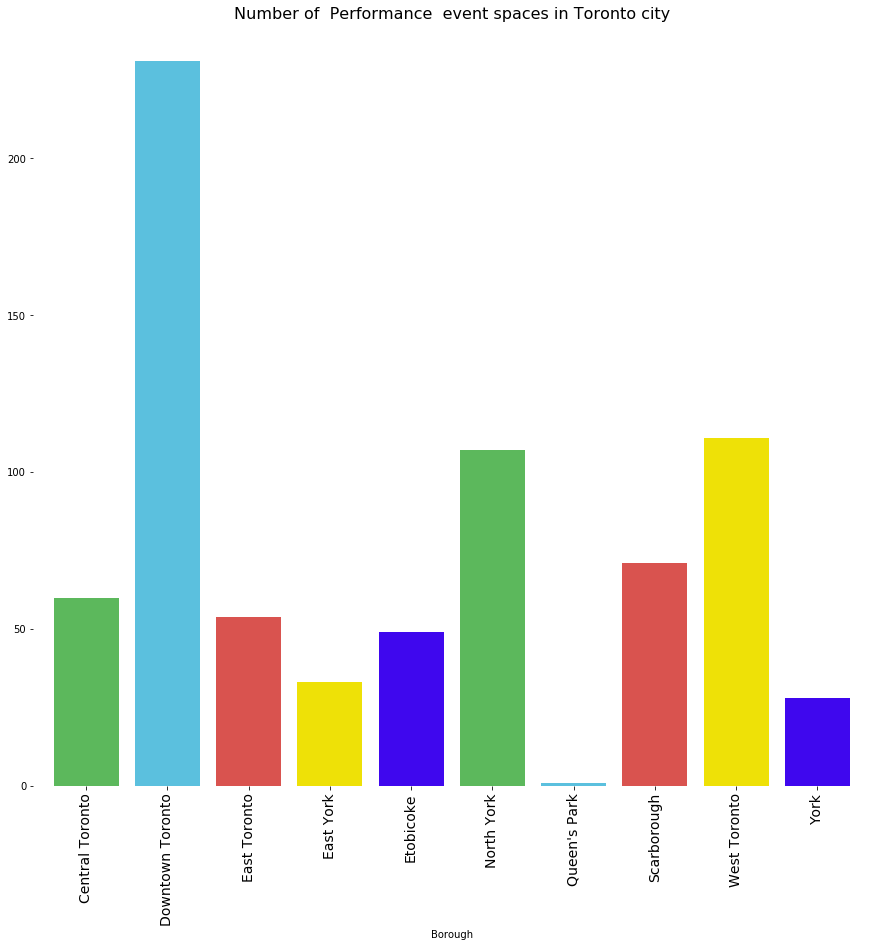

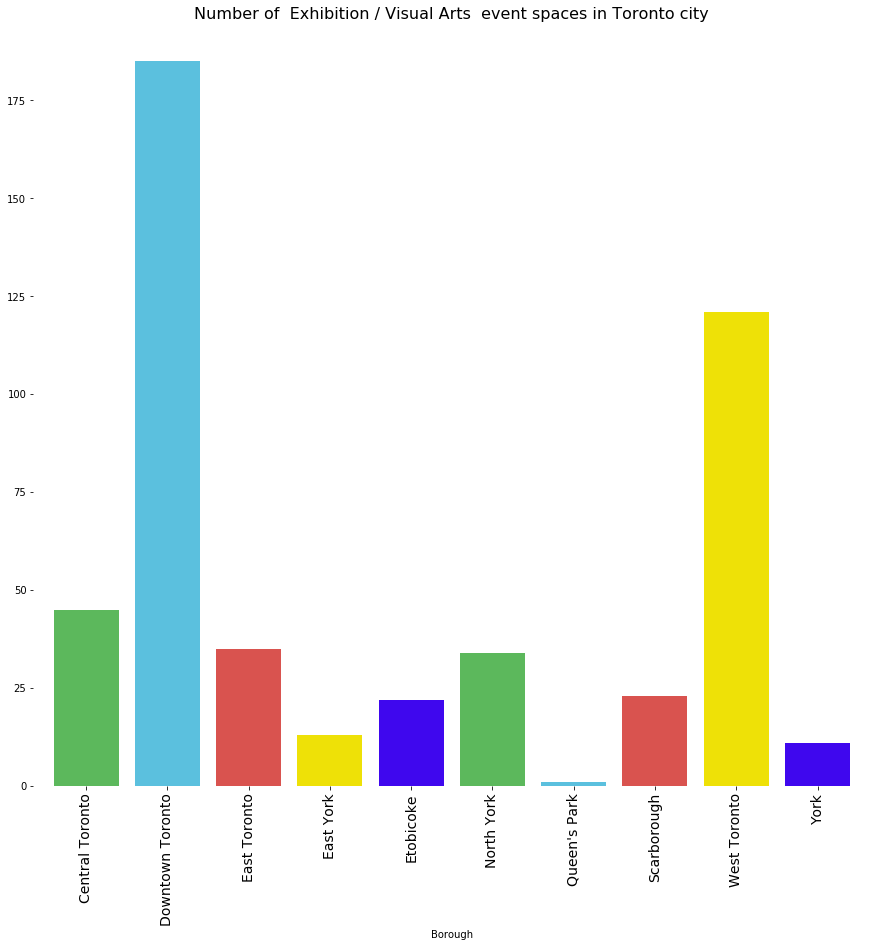

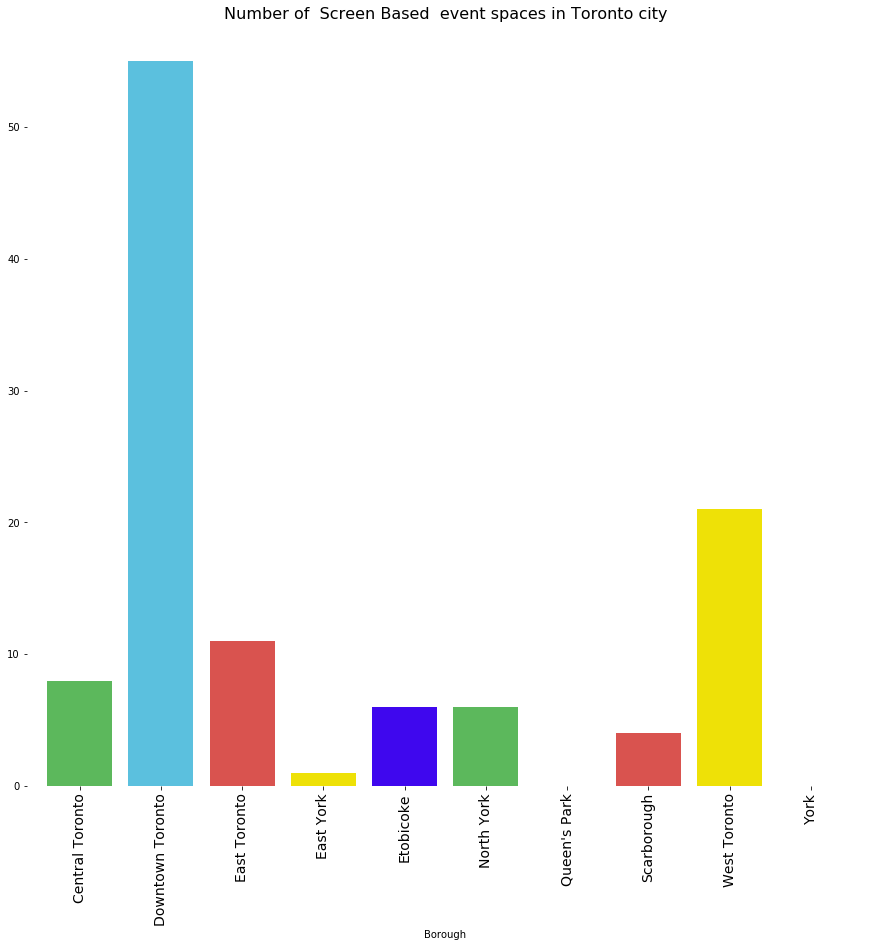

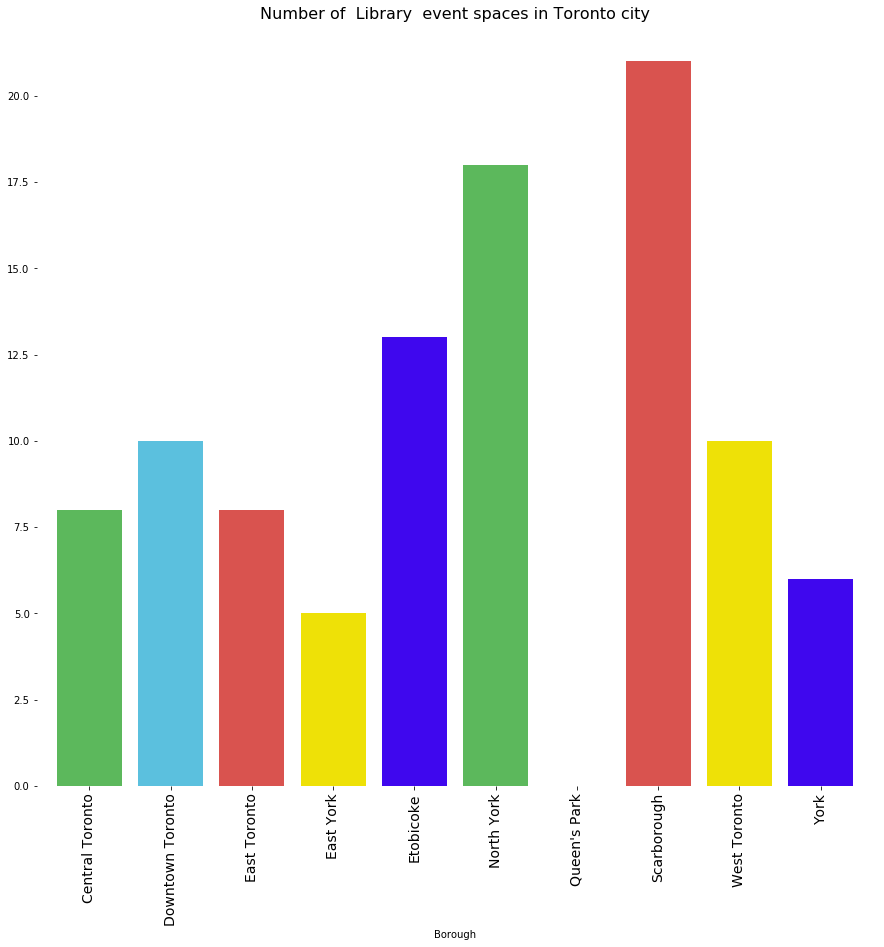

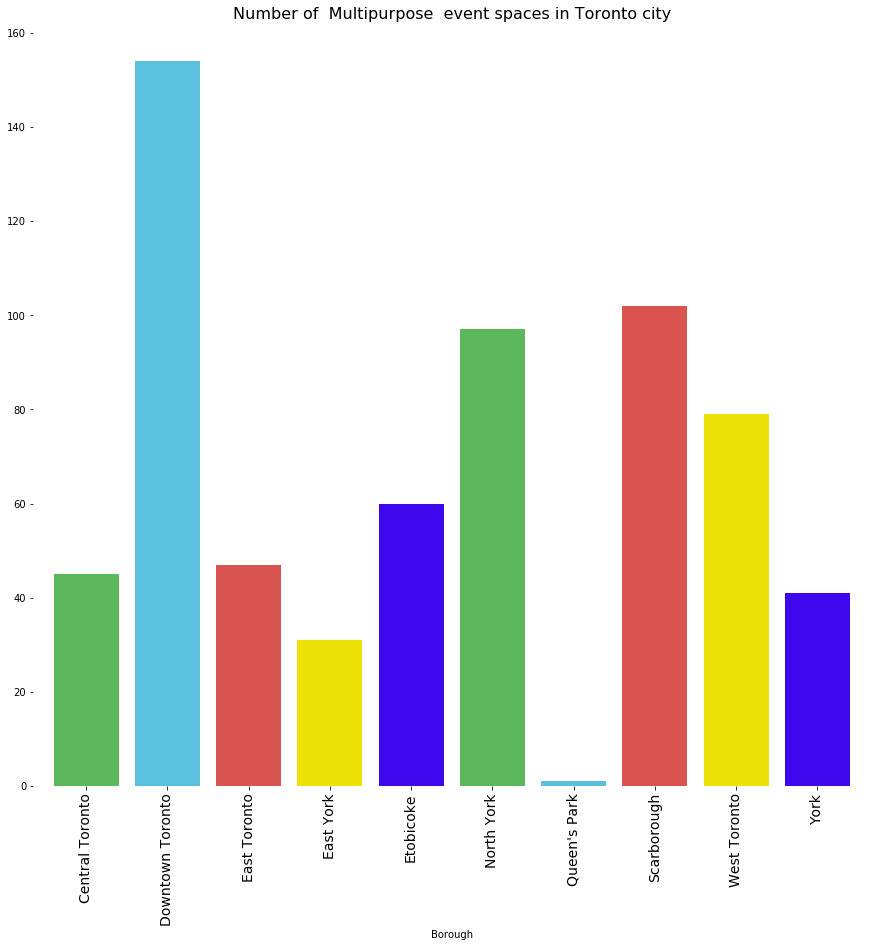

In [12]:
colors_list = ['#5cb85c','#5bc0de','#d9534f', '#EEE107','#3F07EE']

for i in range(5):

# Change this line to plot percentages instead of absolute values
    ax = Facility_visu.iloc[:,i].plot(kind='bar',figsize=(15,14),width = 0.8,color = colors_list,edgecolor=None, )
      
#plt.legend(labels=Facility_visu.columns,fontsize= 14)
    plt.title("Number of  " + Facility_visu.columns[i]+ "  event spaces in Toronto city",fontsize= 16)

    plt.xticks(fontsize=14)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.show()
    plt.savefig('Figure.png')
    plt.close()

Since the available data relate to neighborhood and borough in Toronto city, it is better to do the clustering analysis in that level.  For the sake of illustration, let’s focus on “Multipurpose” facilities in Etobicoke borough which resulted in 60 available facilities.  Next, let's get the location of each event space using Nominatim(). Then the resulting dataset is merged to the selected facilities dataset and cleaned to keep the relevant terms

In [13]:
df_target = df_merged.query("(Multipurpose == 1) & (Borough =='Etobicoke')")
df_target.shape

(60, 18)

In [14]:
df_target.head()

,FACILITY NAME,Full Address,Street #,Street Name,Suite,City,Province,Postal Code,Ward,Performance,Exhibition / Visual Arts,Screen Based,Library,Multipurpose,Heritage,OWNERSHIP,Borough,Neighbourhood
0,Thistletown CC,"925 Albion Road, Toronto, Ontario",925,Albion Road,0,Toronto,ON,M9V,1,1.0,0.0,0.0,0.0,1.0,0.0,City Operated,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam..."
1,Albion Pool & Health Club,"1485 Albion Road, Toronto, Ontario",1485,Albion Road,0,Toronto,ON,M9V,1,0.0,0.0,0.0,0.0,1.0,0.0,City Owned,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam..."
2,Albion Branch (TPL),"1515 Albion Road, Toronto, Ontario",1515,Albion Road,0,Toronto,ON,M9V,1,1.0,0.0,0.0,1.0,1.0,0.0,City Operated,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam..."
4,Humber Arboretum Gardens,"203 Humber College Boulevard, Toronto, Ontario",203,Humber College Boulevard,0,Toronto,ON,M9W,1,0.0,0.0,0.0,0.0,1.0,0.0,City Owned,Etobicoke,Northwest
5,Thistletown Baptist Church,"2534 Kipling Avenue, Toronto, Ontario",2534,Kipling Avenue,0,Toronto,ON,M9V,1,0.0,0.0,0.0,0.0,1.0,0.0,Owned by others,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam..."


##### copy the dataset and work with the copied dataframe

In [15]:
df_copied=df_target.copy()

##### Now let's get the locatiion of each event space. 

In [16]:
geolocator = Nominatim()

In [17]:
column_names=['lat','lon']
x=pd.DataFrame(columns=column_names)
for i in np.arange(df_target.shape[0]):
    address_new=df_target.iloc[i,1]
    location = geolocator.geocode(address_new)
    if location:
        la=location.longitude
        lo=location.latitude
        x= x.append({'lat' : 'la' , 'lon' : lo} , ignore_index=True)
    else :
        la=None
        lo=None
        x= x.append({'lat' : 'la' , 'lon' : lo} , ignore_index=True)

In [18]:
column_names=['lat','lon']
y=pd.DataFrame(columns=column_names)
for i in np.arange(df_target.shape[0]):
    address_new=df_target.iloc[i,1]
    location = geolocator.geocode(address_new)
    if location:
        la=location.latitude
        lo=location.longitude
        y= y.append({'lat' : 'la' , 'lon' : lo} , ignore_index=True)
    else :
        la=None
        lo=None
        y= y.append({'lat' : 'la' , 'lon' : lo} , ignore_index=True)

##### Now the resulting coordinates for the venue spaces are

In [19]:
street_cor=pd.DataFrame(columns=column_names)
street_cor['lat']=x['lon']
street_cor['lon']=y['lon']
#street_cor.reset_index(drop=False, inplace=True)
street_cor.head()

,lat,lon
0,43.735450,-79.562527
1,43.739613,-79.580608
2,43.739871,-79.584810
3,43.729845,-79.603792
4,43.744627,-79.583575


#### Add the locations data to the previous dataframe`

In [20]:
latitude=[] #List to collect the latitudes
longitude=[] #List to collect the longitudes

for ind in np.arange(street_cor.shape[0]):
    try:
        latitude=street_cor['lat']
        longitude=street_cor['lon']
     
    except:
        pass   
    
df_copied['Latitude']=latitude #Adding a column in the main dataframe for Latitude
df_copied['Longitude']=longitude #Adding a column in the main dataframe for Longitude
df_copied.head()

,FACILITY NAME,Full Address,Street #,Street Name,Suite,City,Province,Postal Code,Ward,Performance,Exhibition / Visual Arts,Screen Based,Library,Multipurpose,Heritage,OWNERSHIP,Borough,Neighbourhood,Latitude,Longitude
0,Thistletown CC,"925 Albion Road, Toronto, Ontario",925,Albion Road,0,Toronto,ON,M9V,1,1.0,0.0,0.0,0.0,1.0,0.0,City Operated,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.735450,-79.562527
1,Albion Pool & Health Club,"1485 Albion Road, Toronto, Ontario",1485,Albion Road,0,Toronto,ON,M9V,1,0.0,0.0,0.0,0.0,1.0,0.0,City Owned,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739613,-79.580608
2,Albion Branch (TPL),"1515 Albion Road, Toronto, Ontario",1515,Albion Road,0,Toronto,ON,M9V,1,1.0,0.0,0.0,1.0,1.0,0.0,City Operated,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739871,-79.584810
4,Humber Arboretum Gardens,"203 Humber College Boulevard, Toronto, Ontario",203,Humber College Boulevard,0,Toronto,ON,M9W,1,0.0,0.0,0.0,0.0,1.0,0.0,City Owned,Etobicoke,Northwest,43.744627,-79.583575
5,Thistletown Baptist Church,"2534 Kipling Avenue, Toronto, Ontario",2534,Kipling Avenue,0,Toronto,ON,M9V,1,0.0,0.0,0.0,0.0,1.0,0.0,Owned by others,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.747668,-79.586106


#### let's clean the dataset keeping only the relevant infromatiion

In [21]:
df_copied.columns

Index(['FACILITY NAME', 'Full Address', 'Street #', 'Street Name', 'Suite',
       'City', 'Province', 'Postal Code', 'Ward', 'Performance',
       'Exhibition / Visual Arts', 'Screen Based', 'Library', 'Multipurpose',
       'Heritage', 'OWNERSHIP', 'Borough', 'Neighbourhood', 'Latitude',
       'Longitude'],
      dtype='object')

In [22]:
df_copied.drop(['Street Name'], inplace=True, axis=1)
df_copied.drop(['City'], inplace=True, axis=1)
df_copied.drop(['Province'], inplace=True, axis=1)
df_copied.drop(['Street #'], inplace=True, axis=1)
df_copied.drop(['Suite'], inplace=True, axis=1)
df_copied.drop(['Ward'], inplace=True, axis=1)
df_copied.drop(['Heritage'], inplace=True, axis=1)
df_copied.drop(['OWNERSHIP'], inplace=True, axis=1)

In [23]:
df_copied.head()

,FACILITY NAME,Full Address,Postal Code,Performance,Exhibition / Visual Arts,Screen Based,Library,Multipurpose,Borough,Neighbourhood,Latitude,Longitude
0,Thistletown CC,"925 Albion Road, Toronto, Ontario",M9V,1.0,0.0,0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.735450,-79.562527
1,Albion Pool & Health Club,"1485 Albion Road, Toronto, Ontario",M9V,0.0,0.0,0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739613,-79.580608
2,Albion Branch (TPL),"1515 Albion Road, Toronto, Ontario",M9V,1.0,0.0,0.0,1.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739871,-79.584810
4,Humber Arboretum Gardens,"203 Humber College Boulevard, Toronto, Ontario",M9W,0.0,0.0,0.0,0.0,1.0,Etobicoke,Northwest,43.744627,-79.583575
5,Thistletown Baptist Church,"2534 Kipling Avenue, Toronto, Ontario",M9V,0.0,0.0,0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.747668,-79.586106


##### Rearrange the columns in the dataframe so that location related data are at the beggining

In [24]:
columnsTitles = ['FACILITY NAME', 'Full Address', 'Postal Code', 
       'Borough', 'Neighbourhood', 'Latitude', 'Longitude', 'Performance',
       'Exhibition / Visual Arts', 'Screen Based', 'Library', 'Multipurpose']
df_copied.reindex(columns=columnsTitles).head()

,FACILITY NAME,Full Address,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Performance,Exhibition / Visual Arts,Screen Based,Library,Multipurpose
0,Thistletown CC,"925 Albion Road, Toronto, Ontario",M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.735450,-79.562527,1.0,0.0,0.0,0.0,1.0
1,Albion Pool & Health Club,"1485 Albion Road, Toronto, Ontario",M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739613,-79.580608,0.0,0.0,0.0,0.0,1.0
2,Albion Branch (TPL),"1515 Albion Road, Toronto, Ontario",M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739871,-79.584810,1.0,0.0,0.0,1.0,1.0
4,Humber Arboretum Gardens,"203 Humber College Boulevard, Toronto, Ontario",M9W,Etobicoke,Northwest,43.744627,-79.583575,0.0,0.0,0.0,0.0,1.0
5,Thistletown Baptist Church,"2534 Kipling Avenue, Toronto, Ontario",M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.747668,-79.586106,0.0,0.0,0.0,0.0,1.0


##### Let's clean the dataset further so that we keep only those venue space where the location dataset are not null

In [25]:
df_copied = df_copied[df_copied['Latitude'].notnull() & df_copied['Longitude'].notnull()]
df_copied.head()

,FACILITY NAME,Full Address,Postal Code,Performance,Exhibition / Visual Arts,Screen Based,Library,Multipurpose,Borough,Neighbourhood,Latitude,Longitude
0,Thistletown CC,"925 Albion Road, Toronto, Ontario",M9V,1.0,0.0,0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.735450,-79.562527
1,Albion Pool & Health Club,"1485 Albion Road, Toronto, Ontario",M9V,0.0,0.0,0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739613,-79.580608
2,Albion Branch (TPL),"1515 Albion Road, Toronto, Ontario",M9V,1.0,0.0,0.0,1.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739871,-79.584810
4,Humber Arboretum Gardens,"203 Humber College Boulevard, Toronto, Ontario",M9W,0.0,0.0,0.0,0.0,1.0,Etobicoke,Northwest,43.744627,-79.583575
5,Thistletown Baptist Church,"2534 Kipling Avenue, Toronto, Ontario",M9V,0.0,0.0,0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.747668,-79.586106


In [26]:
df_copied.shape

(47, 12)

Use geopy library to get the latitude and longitude values of Toronto City. In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent t_explorer, as shown below.

In [27]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [28]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, street in zip(df_copied['Latitude'], df_copied['Longitude'], df_copied['Full Address']):
    label = '{}'.format(street)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and Version

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [29]:
CLIENT_ID = 'U1Q44UFGDP5CSB2WVLOPRLVJYDES1KYVHITVR5TNX25TK1NN' # your Foursquare ID
CLIENT_SECRET = 'MTAQ145OYXSDM51QCJNBB3SVEVKI5XCPVQKYYPKBNGO5GNUW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: U1Q44UFGDP5CSB2WVLOPRLVJYDES1KYVHITVR5TNX25TK1NN
CLIENT_SECRET:MTAQ145OYXSDM51QCJNBB3SVEVKI5XCPVQKYYPKBNGO5GNUW


#### Now, let's get the top 150 venues that are in Borough 'Etobicoke' and have a muti purpose facilites within a radius of 700 meters.
First, let's create the GET request URL. Name your URL url.

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=700, LIMIT=150):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Street', 
                  'Street Latitude', 
                  'Street Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each location and create a new dataframe called location_venues and display it.

In [32]:
location_venues = getNearbyVenues(names=df_copied['Full Address'],
                                   latitudes=df_copied['Latitude'],
                                   longitudes=df_copied['Longitude']
                                  )

925 Albion Road, Toronto, Ontario
1485 Albion Road, Toronto, Ontario
1515 Albion Road, Toronto, Ontario
203 Humber College Boulevard, Toronto, Ontario
2534 Kipling Avenue, Toronto, Ontario
2580 Kipling Avenue, Toronto, Ontario
175 Mount Olive Drive, Toronto, Ontario
21 Panorama Court, Toronto, Ontario
10 Rampart Road, Toronto, Ontario
34 Riverdale Drive, Toronto, Ontario
2 Rowntree Road, Toronto, Ontario
33 Carlson Court, Toronto, Ontario
650 Dixon Road, Toronto, Ontario
650 Dixon Road, Toronto, Ontario
801 Dixon Road, Toronto, Ontario
850 Humberwood Boulevard, Toronto, Ontario
2170 Kipling Avenue, Toronto, Ontario
555 Rexdale Boulevard, Toronto, Ontario
31 St. Phillips Road, Toronto, Ontario
130 Lloyd Manor Road, Toronto, Ontario
291 Mill Road, Toronto, Ontario
56 Neilson Drive, Toronto, Ontario
475 Rathburn Road, Toronto, Ontario
590 Rathburn Road, Toronto, Ontario
630 Renforth Drive, Toronto, Ontario
399 The West Mall, Toronto, Ontario
450 The West Mall, Toronto, Ontario
10 Toledo R

In [33]:
location_venues

,Street,Street Latitude,Street Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"925 Albion Road, Toronto, Ontario",43.735450,-79.562527,Drupati's Doubles & Roti Shop,43.736222,-79.563471,Caribbean Restaurant
1,"925 Albion Road, Toronto, Ontario",43.735450,-79.562527,Dairy Queen,43.736232,-79.565309,Fast Food Restaurant
2,"925 Albion Road, Toronto, Ontario",43.735450,-79.562527,Shoppers Drug Mart,43.735361,-79.560221,Pharmacy
3,"925 Albion Road, Toronto, Ontario",43.735450,-79.562527,Rajdhani Sweets & Restaurant,43.738409,-79.566246,Indian Restaurant
4,"925 Albion Road, Toronto, Ontario",43.735450,-79.562527,TD Canada Trust,43.736602,-79.562379,Bank
5,"925 Albion Road, Toronto, Ontario",43.735450,-79.562527,Madras Dosa Hut,43.737156,-79.566460,Indian Restaurant
6,"925 Albion Road, Toronto, Ontario",43.735450,-79.562527,Roti-Roti Family Restaurant,43.736241,-79.563531,Caribbean Restaurant
7,"925 Albion Road, Toronto, Ontario",43.735450,-79.562527,Pizza Pizza,43.736619,-79.564600,Pizza Place
8,"925 Albion Road, Toronto, Ontario",43.735450,-79.562527,Brar Pakwan,43.738082,-79.566037,Indian Restaurant
9,"925 Albion Road, Toronto, Ontario",43.735450,-79.562527,Tim Hortons,43.737881,-79.566891,Coffee Shop


##### we now categorize the resulting data according to street. However, before we do that we make a copy of the data set and get rid of the number from the full adress to keep only the street names. we then explore the dataset.

In [34]:
df_cop=location_venues.copy()

In [35]:
def removedigit(string):
    """
    input is a string 
    output is a string with no digits
    """
    return ''.join(ch for ch in string if not ch.isdigit())
df_cop['Street'] = df_cop['Street'].apply(removedigit)
df_cop.head()

,Street,Street Latitude,Street Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Albion Road, Toronto, Ontario",43.73545,-79.562527,Drupati's Doubles & Roti Shop,43.736222,-79.563471,Caribbean Restaurant
1,"Albion Road, Toronto, Ontario",43.73545,-79.562527,Dairy Queen,43.736232,-79.565309,Fast Food Restaurant
2,"Albion Road, Toronto, Ontario",43.73545,-79.562527,Shoppers Drug Mart,43.735361,-79.560221,Pharmacy
3,"Albion Road, Toronto, Ontario",43.73545,-79.562527,Rajdhani Sweets & Restaurant,43.738409,-79.566246,Indian Restaurant
4,"Albion Road, Toronto, Ontario",43.73545,-79.562527,TD Canada Trust,43.736602,-79.562379,Bank


In [36]:
location_venues.groupby('Street').count()

,Street Latitude,Street Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Street,,,,,,
"10 Rampart Road, Toronto, Ontario",7,7,7,7,7,7
"10 Toledo Road, Toronto, Ontario",4,4,4,4,4,4
"105 Norseman Street, Toronto, Ontario",18,18,18,18,18,18
"130 Lloyd Manor Road, Toronto, Ontario",11,11,11,11,11,11
"1428 Royal York Road, Toronto, Ontario",16,16,16,16,16,16
"1485 Albion Road, Toronto, Ontario",9,9,9,9,9,9
"15 Canmotor Avenue, Toronto, Ontario",17,17,17,17,17,17
"15 Trehorne Drive, Toronto, Ontario",40,40,40,40,40,40
"1515 Albion Road, Toronto, Ontario",12,12,12,12,12,12


In [37]:
# determine the List of Unique Categories
print('There are {} uniques categories.'.format(len(location_venues['Venue Category'].unique())))

There are 121 uniques categories.


In [38]:
location_venues.shape

(797, 7)

##### Analyze Each Street

In [39]:
# one hot encoding
venues_onehot = pd.get_dummies(location_venues[['Venue Category']], prefix="", prefix_sep="")

# add street column back to dataframe
venues_onehot['Street'] = location_venues['Street'] 

# move street column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])

#fixed_columns
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Street,Adult Boutique,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Beer Store,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Coffee Shop,College Rec Center,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Music Venue,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Racecourse,Racetrack,Rental Car Location,Restaurant,Sandwich Place,Seafood Restaurant,Shipping Store,Shopping Mall,Skating Rink,Smoothie Shop,Social Club,Spa,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tanning Salon,Tapas Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Train Station,Turkish Restaurant,Video Game Store,Video Store,Warehouse Store,Wings Joint,Yoga Studio
0,"925 Albion Road, Toronto, Ontario",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"925 Albion Road, Toronto, Ontario",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"925 Albion Road, Toronto, Ontario",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"925 Albion Road, Toronto, Ontario",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"925 Albion Road, Toronto, Ontario",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Next, let's group rows by Street and by taking the mean of the frequency of occurrence of each category

In [40]:
Etobicoke_grouped = venues_onehot.groupby('Street').mean().reset_index()
Etobicoke_grouped

,Street,Adult Boutique,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Beer Store,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Coffee Shop,College Rec Center,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Music Venue,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Racecourse,Racetrack,Rental Car Location,Restaurant,Sandwich Place,Seafood Restaurant,Shipping Store,Shopping Mall,Skating Rink,Smoothie Shop,Social Club,Spa,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tanning Salon,Tapas Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Train Station,Turkish Restaurant,Video Game Store,Video Store,Warehouse Store,Wings Joint,Yoga Studio
0,"10 Rampart Road, Toronto, Ontario",0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"10 Toledo Road, Toronto, Ontario",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"105 Norseman Street, Toronto, Ontario",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.055556,0.000000,

In [41]:
Etobicoke_grouped.shape

(46, 122)

In [42]:
# What are the top 5 venues nearby multi-purpose facilities

num_top_venues = 5

for hood in Etobicoke_grouped['Street']:
    print("----"+hood+"----")
    temp = Etobicoke_grouped[Etobicoke_grouped['Street'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----10 Rampart Road, Toronto, Ontario----
                  venue  freq
0  Caribbean Restaurant  0.29
1      Asian Restaurant  0.14
2           Supermarket  0.14
3       Thai Restaurant  0.14
4                  Bank  0.14


----10 Toledo Road, Toronto, Ontario----
                  venue  freq
0  Gym / Fitness Center  0.25
1         Shopping Mall  0.25
2        Baseball Field  0.25
3                  Park  0.25
4        Adult Boutique  0.00


----105 Norseman Street, Toronto, Ontario----
               venue  freq
0  Indian Restaurant  0.11
1      Grocery Store  0.11
2  Convenience Store  0.11
3     Breakfast Spot  0.06
4        Coffee Shop  0.06


----130 Lloyd Manor Road, Toronto, Ontario----
               venue  freq
0              Hotel  0.09
1            Theater  0.09
2  Convenience Store  0.09
3     Farmers Market  0.09
4       Skating Rink  0.09


----1428 Royal York Road, Toronto, Ontario----
                  venue  freq
0     Convenience Store  0.19
1        Sandwich Place  

In [43]:
# Define a function to return the most common venues nearby multi-putpose facilities

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Street']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [45]:
# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Street'] = Etobicoke_grouped['Street']

for ind in np.arange(Etobicoke_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(Etobicoke_grouped.iloc[ind, :], num_top_venues)
venues_sorted.head()

,Street,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"10 Rampart Road, Toronto, Ontario",Caribbean Restaurant,Supermarket,Thai Restaurant,Asian Restaurant,Pharmacy,Bank,Fast Food Restaurant,Farmers Market,Event Space,Electronics Store
1,"10 Toledo Road, Toronto, Ontario",Gym / Fitness Center,Shopping Mall,Baseball Field,Park,Yoga Studio,Fast Food Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner
2,"105 Norseman Street, Toronto, Ontario",Grocery Store,Convenience Store,Indian Restaurant,Pharmacy,Skating Rink,Café,Coffee Shop,Breakfast Spot,Beer Store,Thai Restaurant
3,"130 Lloyd Manor Road, Toronto, Ontario",Theater,Bank,Mexican Restaurant,Farmers Market,Skating Rink,Clothing Store,Coffee Shop,Café,Hotel,Convenience Store
4,"1428 Royal York Road, Toronto, Ontario",Convenience Store,Sandwich Place,Coffee Shop,Fast Food Restaurant,Donut Shop,Shopping Mall,Gym / Fitness Center,Clothing Store,Pharmacy,Deli / Bodega


##### After investigation of venues nearby event spaces in Toronto London, we could begin clustering them. Before clustering however let's find the optimum number of cluster using the Elbow Curve method

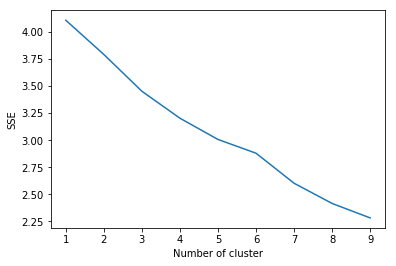

<Figure size 432x288 with 0 Axes>

In [46]:
Etobicoke_grouped_clustering = Etobicoke_grouped.drop('Street', 1)
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(Etobicoke_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()
plt.savefig('optimal.png')

In [47]:
# based on the above plot we choose to distribute the dataset in 5 Clusters

# set number of clusters
kclusters = 3
Etobicoke_grouped_clustering = Etobicoke_grouped.drop('Street', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Etobicoke_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50]

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0], dtype=int32)

In [48]:
Etobicoke_grouped_clustering.head()

,Adult Boutique,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Beer Store,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Coffee Shop,College Rec Center,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Music Venue,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Racecourse,Racetrack,Rental Car Location,Restaurant,Sandwich Place,Seafood Restaurant,Shipping Store,Shopping Mall,Skating Rink,Smoothie Shop,Social Club,Spa,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tanning Salon,Tapas Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Train Station,Turkish Restaurant,Video Game Store,Video Store,Warehouse Store,Wings Joint,Yoga Studio
0,0.0,0.000000,0.142857,0.0,0.0,0.0,0.142857,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.285714,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000,0.0,0.0000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.25,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.2500,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000,0.0,0.0000,0.2500,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.055556,0.055556,0.00,0.055556,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.055556,0.0,0.0,0.0,0.0,0.111111,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.055556,0.055556,0.055556,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000,0.0,0.0000,0.0000,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.055556,0.000000,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.090909,0.000000,0.0,0.0,0.0,0.090909,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909,0.090909,0.0,0.0,0.0,0.0,0.090909,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.090909,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.000000,0.000

In [49]:
df_copied.rename(columns={'Full Address':'Street'}, inplace=True)

In [50]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_, allow_duplicates=False)

Etobicoke_merged = df_copied

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Etobicoke_merged = Etobicoke_merged.join(venues_sorted.set_index('Street'), on='Street')

Etobicoke_merged.head() 

,FACILITY NAME,Street,Postal Code,Performance,Exhibition / Visual Arts,Screen Based,Library,Multipurpose,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Thistletown CC,"925 Albion Road, Toronto, Ontario",M9V,1.0,0.0,0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.735450,-79.562527,0,Indian Restaurant,Caribbean Restaurant,Pizza Place,Asian Restaurant,Pharmacy,Supermarket,Bank,Coffee Shop,Fast Food Restaurant,Thai Restaurant
1,Albion Pool & Health Club,"1485 Albion Road, Toronto, Ontario",M9V,0.0,0.0,0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739613,-79.580608,0,Hardware Store,Pizza Place,Fried Chicken Joint,Beer Store,Liquor Store,Pharmacy,Fast Food Restaurant,Grocery Store,Video Store,Diner
2,Albion Branch (TPL),"1515 Albion Road, Toronto, Ontario",M9V,1.0,0.0,0.0,1.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739871,-79.584810,0,Grocery Store,Hardware Store,Coffee Shop,Fast Food Restaurant,Beer Store,Fried Chicken Joint,Sandwich Place,Liquor Store,Pharmacy,Pizza Place
4,Humber Arboretum Gardens,"203 Humber College Boulevard, Toronto, Ontario",M9W,0.0,0.0,0.0,0.0,1.0,Etobicoke,Northwest,43.744627,-79.583575,0,Grocery Store,Coffee Shop,Fast Food Restaurant,Pharmacy,Park,Sandwich Place,Beer Store,Fried Chicken Joint,Pizza Place,Video Store
5,Thistletown Baptist Church,"2534 Kipling Avenue, Toronto, Ontario",M9V,0.0,0.0,0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.747668,-79.586106,0,Coffee Shop,Fast Food Restaurant,Liquor Store,Grocery Store,Pizza Place,Japanese Restaurant,Sandwich Place,Beer Store,Park,Eastern European Restaurant


#### Finally, let's visualize the resulting clusters

In [51]:
# Create Map

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Etobicoke_merged['Latitude'], Etobicoke_merged['Longitude'], Etobicoke_merged['Street'], Etobicoke_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Cluster

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 1

In [52]:
Etobicoke_merged.loc[Etobicoke_merged['Cluster Labels'] == 0, Etobicoke_merged.columns[[1] + list(range(5, Etobicoke_merged.shape[1]))]]

,Street,Screen Based,Library,Multipurpose,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"925 Albion Road, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.735450,-79.562527,0,Indian Restaurant,Caribbean Restaurant,Pizza Place,Asian Restaurant,Pharmacy,Supermarket,Bank,Coffee Shop,Fast Food Restaurant,Thai Restaurant
1,"1485 Albion Road, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739613,-79.580608,0,Hardware Store,Pizza Place,Fried Chicken Joint,Beer Store,Liquor Store,Pharmacy,Fast Food Restaurant,Grocery Store,Video Store,Diner
2,"1515 Albion Road, Toronto, Ontario",0.0,1.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739871,-79.584810,0,Grocery Store,Hardware Store,Coffee Shop,Fast Food Restaurant,Beer Store,Fried Chicken Joint,Sandwich Place,Liquor Store,Pharmacy,Pizza Place
4,"203 Humber College Boulevard, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,Northwest,43.744627,-79.583575,0,Grocery Store,Coffee Shop,Fast Food Restaurant,Pharmacy,Park,Sandwich Place,Beer Store,Fried Chicken Joint,Pizza Place,Video Store
5,"2534 Kipling Avenue, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.747668,-79.586106,0,Coffee Shop,Fast Food Restaurant,Liquor Store,Grocery Store,Pizza Place,Japanese Restaurant,Sandwich Place,Beer Store,Park,Eastern European Restaurant
6,"2580 Kipling Avenue, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.749735,-79.596359,0,Pool,Deli / Bodega,Pizza Place,Shopping Mall,Yoga Studio,Fast Food Restaurant,Department Store,Dessert Shop,Diner,Discount Store
7,"175 Mount Olive Drive, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.746311,-79.581547,0,Fried Chicken Joint,Pharmacy,Fast Food Restaurant,Japanese Restaurant,Park,Beer Store,Coffee Shop,Liquor Store,Pizza Place,Grocery Store
8,"21 Panorama Court, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.734794,-79.588682,0,Construction & Landscaping,Grocery Store,Pizza Place,Bus Line,Gym,Fast Food Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner
9,"10 Rampart Road, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.731250,-79.559720,0,Caribbean Restaurant,Supermarket,Thai Restaurant,Asian Restaurant,Pharmacy,Bank,Fast Food Restaurant,Farmers Market,Event Space,Electronics Store
11,"2 Rowntree Road, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.690239,-79.583648,0,Hotel,American Restaurant,Coffee Shop,Steakhouse,Sushi Restaurant,Restaurant,Rental Car Location,Breakfast Spot,Thai Restaurant,Mexican Restaurant


#### Cluster 2

In [53]:
Etobicoke_merged.loc[Etobicoke_merged['Cluster Labels'] == 1, Etobicoke_merged.columns[[1] + list(range(5, Etobicoke_merged.shape[1]))]]

,Street,Screen Based,Library,Multipurpose,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"555 Rexdale Boulevard, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,Northwest,43.638157,-79.579916,1,Convenience Store,Beer Store,Pizza Place,Pharmacy,Café,Flower Shop,Liquor Store,Gastropub,Farmers Market,Department Store
26,"130 Lloyd Manor Road, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Cloverdale,Islington,Martin Grove,Princess Gar...",43.647058,-79.568018,1,Theater,Bank,Mexican Restaurant,Farmers Market,Skating Rink,Clothing Store,Coffee Shop,Café,Hotel,Convenience Store
27,"291 Mill Road, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Bloordale Gardens,Eringate,Markland Wood,Old B...",43.639932,-79.572752,1,Liquor Store,Beer Store,Pizza Place,Pharmacy,Coffee Shop,Skating Rink,Farmers Market,Café,Convenience Store,Fried Chicken Joint
31,"630 Renforth Drive, Toronto, Ontario",1.0,0.0,1.0,Etobicoke,"Bloordale Gardens,Eringate,Markland Wood,Old B...",43.684855,-79.528277,1,Plaza,Convenience Store,Hardware Store,Pizza Place,Bakery,Bank,Restaurant,Café,Eastern European Restaurant,Farmers Market
33,"399 The West Mall, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Bloordale Gardens,Eringate,Markland Wood,Old B...",43.665125,-79.528947,1,Pharmacy,Convenience Store,Bank,Skating Rink,Shopping Mall,Park,Café,Bakery,Grocery Store,Dessert Shop
39,"1428 Royal York Road, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,Westmount,43.637845,-79.555379,1,Convenience Store,Sandwich Place,Coffee Shop,Fast Food Restaurant,Donut Shop,Shopping Mall,Gym / Fitness Center,Clothing Store,Pharmacy,Deli / Bodega
42,"86 Montgomery Road, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,Islington Avenue,43.646135,-79.559096,1,Convenience Store,Theater,Bank,Farmers Market,Clothing Store,Mexican Restaurant,Café,Hotel,Grocery Store,Gym
57,"105 Norseman Street, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Kingsway Park South West,Mimico NW,The Queensw...",43.612146,-79.496272,1,Grocery Store,Convenience Store,Indian Restaurant,Pharmacy,Skating Rink,Café,Coffee Shop,Breakfast Spot,Beer Store,Thai Restaurant


#### Cluster 3

In [54]:
Etobicoke_merged.loc[Etobicoke_merged['Cluster Labels'] == 2, Etobicoke_merged.columns[[1] + list(range(5, Etobicoke_merged.shape[1]))]]

,Street,Screen Based,Library,Multipurpose,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,"34 Riverdale Drive, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.752519,-79.584733,2,Coffee Shop,BBQ Joint,Bank,Park,Eastern European Restaurant,Fast Food Restaurant,Farmers Market,Event Space,Electronics Store,Yoga Studio
47,"3326 Bloor Street West, Toronto, Ontario",0.0,0.0,1.0,Etobicoke,"The Kingsway,Montgomery Road,Old Mill North",43.634084,-79.492077,2,Coffee Shop,Park,Sushi Restaurant,Yoga Studio,Fish & Chips Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store


## 4. Results

The resulting clusters are very insightful in arriving at the appropriate event spaces that suits the participants. Let’s consider them in detail:

#### Cluster 1: These event spaces are suitable for: 
•	Celebrations 
•	Receptions,
•	Small-scale live performance
•	Cocktail and dinner parties

##### Key characteristics: 

o	Extra convenience and increased access to resource to participants

o	Availability of rooms for rent and nearby restaurants

o	Modern architectures add coziness and intimate feeling to event attendees.

o	There might be parking constraint as it is the most eventful venue


#### Cluster 2: These event spaces are suitable for:
•	Luncheons
•	Conferences
•	Workshops
•	Networking
•	Team building
•	Live music

##### Key characteristics: 

o	Usher a mix of socializing and business atmosphere

o	Diversity of popular venues that can be provide customizable event space

o	Popular venues have several social hubs that could facilitate organic networking


#### Cluster 3: These event spaces are suitable for:
•	Company retreats
•	Fund raisers
•	Corporate meetings
•	Galas
•	Themed parties
•	Private performance

##### Key characteristics:

o	Less eventful venues that are dominated by parks, home services and auto workshops 

o	Venues best reached by car since there is low density of public transport 

o	There is however ample parking space


## 5. Discussion and conclusion

An effort has been made to facilitate decision regarding even space in Toronto city. The procedure was to get information regarding all available facilities such as type of facility and full address. This was combined with another dataset that contained neighborhood and borough information. The latter dataset helps in the decision process to enable selection of facilities in each region. This decision information together with the type of event space is used to find popular venues near the selected regions that consist of the desired venue spaces.

Finally, it was possible to analyze the results according to the five clusters. Clusters gave out popular venues that could help achieve great event space. One could see, especially for cluster number 2, 4, and 5 that a pattern emerges in direct relation to the busy-ness of the venue and the type of services available. Particularly cluster 4 is ideal places for artist who would like to perform in Etobicoke region. This is owning to the presence of great opportunities for organic event networking.

In conclusion, this project successfully find and cluster great venues nearby available event facilities in a city that fulfill the types of events and their requirements.In addition, emerging patterns in cluster could be used as a prime indicators to select great venue spaces that facilitated decision for event coordinators. 